Names: Philipp Köhler, Alexander Bespalov


# Sheet 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import pyplot as plt
%matplotlib inline

## 1 Principal Component Analysis
### (a)

In [2]:
# TODO: implement PCA (fill in the blanks in the function below)

def pca(data, n_components=None):
    """
    Principal Component Analysis on a p x N data matrix.
    
    Parameters
    ----------
    data : np.ndarray
        Data matrix of shape (p, N).
    n_components : int, optional
        Number of requested components. By default returns all components.
        
    Returns
    -------
    np.ndarray, np.ndarray
        the pca components (shape (n_components, p)) and the projection (shape (n_components, N))

    """
    # set n_components to p by default
    n_components = data.shape[0] if n_components is None else n_components
    assert n_components <= data.shape[0], f"Got n_components larger than dimensionality of data!"
    
    # center the data
    C = (np.eye(data.shape[1]) - np.ones((data.shape[1],1)) @ np.ones((data.shape[1],1)).T/data.shape[1])
    x_centered = data @ C
    
    # compute X times X transpose
    xxt = x_centered @ x_centered.T
    
    # compute the eigenvectors and eigenvalues
    eigenvalues, eigenvectors = np.linalg.eig(xxt)
    
    # sort the eigenvectors by eigenvalue and take the n_components largest ones
    sorted_indices = np.argsort(eigenvalues)[::-1]
    components = eigenvectors[:, sorted_indices][:, :n_components].T #directly use only first n_components and traspose for correct dimensions
    
    # compute X_projected, the projection of the data to the components
    X_projected = components @ x_centered
    
    return components, X_projected  # return the n_components first components and the pca projection of the data


In [3]:
# Example data to test your implementation 
# All the asserts on the bottom should go through if your implementation is correct

data = np.array([
    [ 1,  0,  0, -1,  0,  0],
    [ 0,  3,  0,  0, -3,  0],
    [ 0,  0,  5,  0,  0, -5]
], dtype=np.float32)

# add a random offset to all samples. it should not affect the results
data += np.random.randn(data.shape[0], 1)

n_components = 2
components, projection = pca(data, n_components=n_components)  # apply your implementation

# the correct results are known (up to some signs)
true_components = np.array([[0, 0, 1], [0, 1, 0]], dtype=np.float32)
true_projection = np.array([
    [ 0,  0,  5,  0,  0, -5],
    [ 0,  3,  0,  0, -3,  0]
], dtype=np.float32)

# check that components match, up to sign
assert isinstance(components, np.ndarray), f'Expected components to be numpy array but got {type(components)}'
assert components.shape == true_components.shape, f'{components.shape}!={true_components.shape}'
assert np.allclose(np.abs(components * true_components).sum(1), np.ones(n_components)), f'Components not matching'

# check that projections agree, taking into account potentially flipped components
assert isinstance(projection, np.ndarray), f'Expected projection to be numpy array but got {type(projection)}'
assert projection.shape == (n_components, data.shape[1]), f'Incorrect shape of projection: Expected {(n_components, data.shape[1])}, got {projection.shape}'
assert np.allclose(projection, true_projection * (components * true_components).sum(1, keepdims=True), atol=1e-6), f'Projections not matching'

print('Test successful!')

Test successful!


### (b)

Load the data (it is a subset of the data at https://opendata.cern.ch/record/4910#)

In [4]:
features = np.load('data/dijet_features.npy')
labels = np.load('data/dijet_labels.npy')
label_names = ['b', 'c', 'q']  # bottom, charm or light quarks

print(f'{features.shape=}, {labels.shape=}')  # print the shapes

# TODO: print how many samples of each class are present in the data (hint: numpy.unique)
unique_labels, counts = np.unique(labels, return_counts=True)

for label, count in zip(unique_labels, counts):
    print(f'Class {label_names[int(label)]}: {count} samples')

features.shape=(116, 2233), labels.shape=(2233,)
Class b: 999 samples
Class c: 864 samples
Class q: 370 samples


Normalize the data

In [5]:
# TODO: report range of features and normalize the data to zero mean and unit variance

feature_min = np.min(features, axis=1)  
feature_max = np.max(features, axis=1)  
feature_range = feature_max - feature_min  

print("Feature ranges (min, max):")
for i in range(features.shape[0]):
    print(f"Feature {i}: min={feature_min[i]}, max={feature_max[i]}, range={feature_range[i]}")

mean = np.mean(features, axis=1,keepdims=True)
std_dev = np.std(features, axis=1,keepdims=True)

normalized_features = (features - mean) / std_dev

print("\nNormalized Features:")
print(f"Mean of normalized features: {np.mean(normalized_features, axis=1)}")
print(f"Standard deviation of normalized features: {np.std(normalized_features, axis=1)}")
print(mean.shape)

Feature ranges (min, max):
Feature 0: min=0.5857568129500379, max=1.0563076922743733, range=0.47055087932433537
Feature 1: min=-0.324, max=0.3001, range=0.6241
Feature 2: min=-139.62783040862374, max=145.8169283242588, range=285.4447587328825
Feature 3: min=11.65252474327396, max=20713.95643348941, range=20702.303908746137
Feature 4: min=99860.37217253156, max=100145.81693106721, range=285.4447585356538
Feature 5: min=-0.9999999932105357, max=-0.9782917490360855, range=0.021708244174450164
Feature 6: min=149256.83013332827, max=2725986.9412642987, range=2576730.1111309705
Feature 7: min=94.02340841282924, max=231315.8411330428, range=231221.81772462997
Feature 8: min=155058.36476195962, max=2728662.5177883604, range=2573604.1530264006
Feature 9: min=-134437.84306900043, max=59292.72195058862, range=193730.56501958903
Feature 10: min=-96619.36772098255, max=188237.84080264496, range=284857.2085236275
Feature 11: min=149077.9934216972, max=2725850.600345601, range=2576772.606923904
Featu

### (c)
Compute a 2D PCA projection and make a scatterplot of the result, once without color, once coloring the dots by label. Interpret your results.

In [6]:
# TODO: apply PCA as implemented in (a)
n_components = 2
components, projection = pca(normalized_features, n_components=n_components)

c:\Users\sasch\miniconda3\envs\mlph\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\sasch\miniconda3\envs\mlph\lib\site-packages\matplotlib\collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


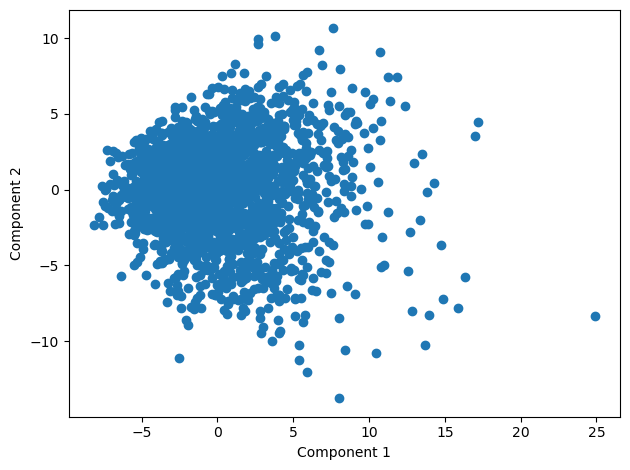

In [7]:
# TODO: make a scatterplot of the PCA projection
plt.scatter(projection[0], projection[1])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()

No clusters of classes can be seen.

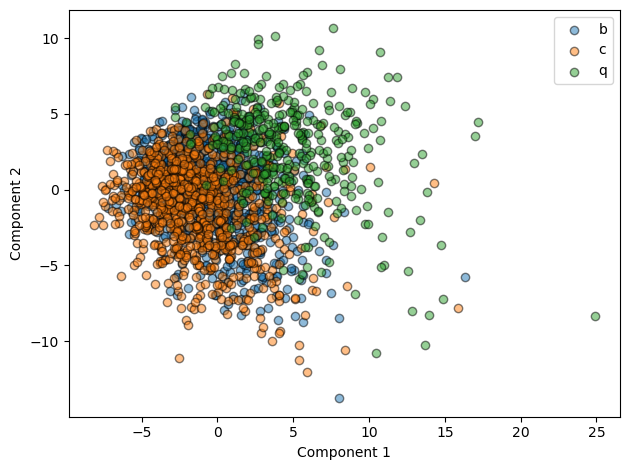

In [8]:
# TODO: make a scatterplot, coloring the dots by their label and including a legend with the label names
# (hint: one way is to call plt.scatter once for each of the three possible labels. Why could it be problematic to scatter the data sorted by labels though?)
for label in np.unique(labels):
    plt.scatter(
        projection[0][labels == label],  
        projection[1][labels == label],  
        label=label_names[int(label)],                  
        alpha=0.5,                         
        edgecolor='k'                              
    )
plt.legend()
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()

The classes b and c are well mixed. The class q is overlappig but more distinct.

## 2 Nonlinear Dimension Reduction

In [9]:
import umap  # import umap-learn, see https://umap-learn.readthedocs.io/

In [10]:
# if you have not done 1(b) yet, you can load the normalized features directly:
features = np.load('data/dijet_features_normalized.npy')
labels = np.load('data/dijet_labels.npy')
label_names = ['b', 'c', 'q']  # bottom, charm or light quarks

### (a)

In [11]:
# TODO: Apply umap on the normalized jet features from excercise 1. It will take a couple of seconds.
# note: umap uses a different convention regarding the feature- and sample dimension, N x p instead of p x N!

reducer = umap.UMAP()
umap_projection = reducer.fit_transform(normalized_features.T)

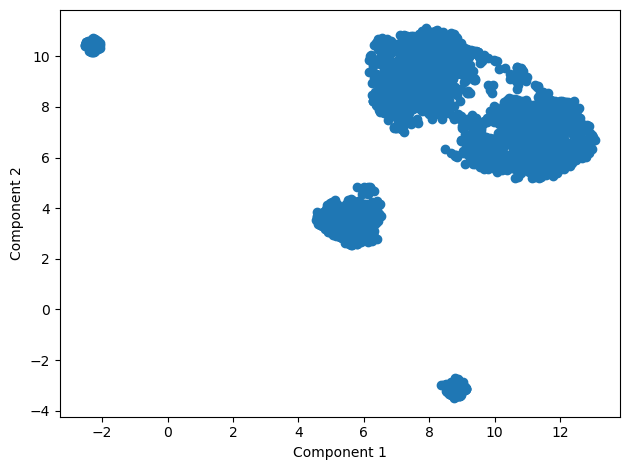

In [12]:
# TODO: make a scatterplot of the UMAP projection
plt.scatter(umap_projection[:,0], umap_projection[:,1])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()

5 cluster groups are visible.

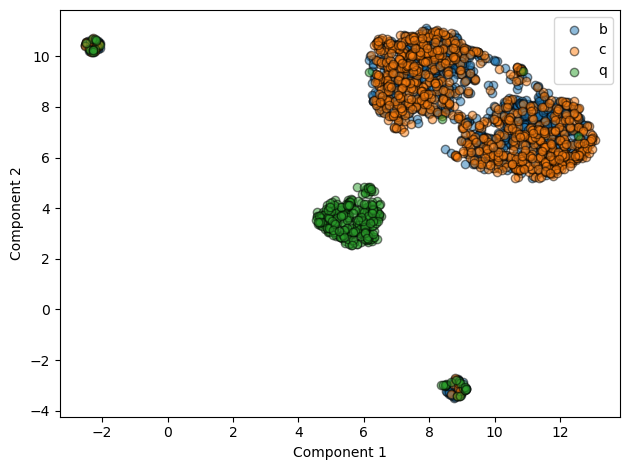

In [13]:
# TODO: make a scatterplot, coloring the dots by their label and including a legend with the label names
for label in np.unique(labels):
    plt.scatter(
        umap_projection[labels == label, 0],
        umap_projection[labels == label, 1],  
        label=label_names[int(label)],             
        alpha=0.5,          
        edgecolor='k'                         
    )
plt.legend()
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()

At (6,2) a q cluster is clearly seen. At (4.5, -4) and (-2,6) are two small clusters with q and c dominating and b also contained. The two clusters around (10, 8) are dominated by c and b with a low amount of q.

### (b)

c:\Users\sasch\miniconda3\envs\mlph\lib\site-packages\sklearn\manifold\_spectral_embedding.py:455: UserWarning: Exited at iteration 648 with accuracies 
[1.38043604e-15 5.97961793e-06 1.68046949e-06 4.60862444e-06]
not reaching the requested tolerance 4.664063453674316e-06.
Use iteration 648 instead with accuracy 
3.0671779640798114e-06.

  _, diffusion_map = lobpcg(
c:\Users\sasch\miniconda3\envs\mlph\lib\site-packages\sklearn\manifold\_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[1.68076127e-15 5.97960806e-06 1.68052754e-06 4.60861606e-06]
not reaching the requested tolerance 4.664063453674316e-06.
  _, diffusion_map = lobpcg(
c:\Users\sasch\miniconda3\envs\mlph\lib\site-packages\umap\spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


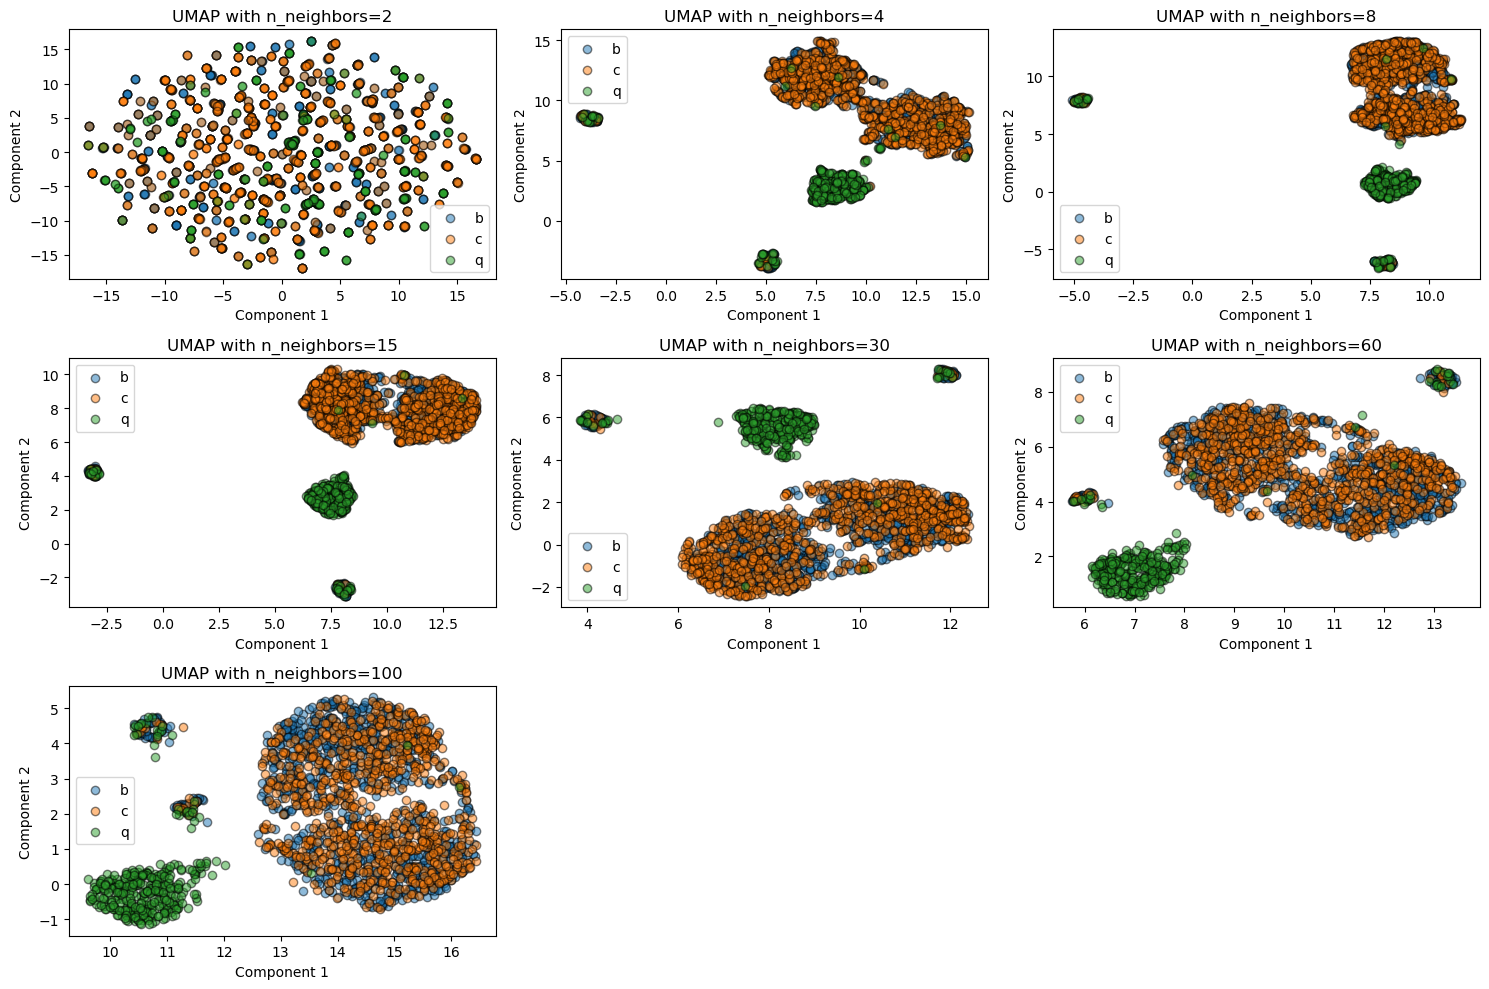

In [14]:
plt.figure(figsize=(15, 10))

n_neighbors_values = (2, 4, 8, 15, 30, 60, 100)

for i, n_neighbors in enumerate(n_neighbors_values):
    reducer = umap.UMAP(n_neighbors=n_neighbors)
    umap_projection = reducer.fit_transform(normalized_features.T)
    
    # Create a subplot for the current n_neighbors
    plt.subplot(3, 3, i + 1)  # 3 rows, 3 columns
    plt.title(f'UMAP with n_neighbors={n_neighbors}')
    
    for label in np.unique(labels):
        plt.scatter(
            umap_projection[labels == label, 0],  
            umap_projection[labels == label, 1],  
            label=label_names[int(label)],        
            alpha=0.5,                            
            edgecolor='k'                         
        )
    plt.legend()
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.tight_layout()
    
    
#plt.subplot(3, 3, len(n_neighbors_values))  # Select the last subplot for the legend
#plt.legend(title='Label', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()  
plt.show()   

For 2 neighbours the dataset is mixed. A value above 4 n_neighbours does not improve the clustering. It just changes the postitions of the clusters. Higher values for neighbours thend to spread the clusters.

## 3 RANSAC

Probability to sample $m$ inliers: $$p^m$$
Probabiltiy to not sample $m$ inliers: $$1-p^m$$
Probability to sample $r$ times not $m$ inliers: $$(1-p^m)^r$$
Probability to not sample $r$ times not $m$ inliers: $$1-(1-p^m)^r \overset{!}{=} 0.99$$
$$ \Leftrightarrow r = \frac{log(1-0.99)}{log(1-p^m)}$$

## 4 Bonus: PCA meets Random Matrix Theory

### (a)

The directional distribution of all principal componets is isotropic gaussian, because they are random variables of an isotropic gaussian distributed random variable $\mathbf{X}$ with PCA applied wich conserves the property due to linearity.

### (b)

Largest eigenvalues will grow with $N$. Middle eigenvalues are influenced by the ratio of $p$ and $N$. Most eigenvalues will be zero.

### (c)

According to Marchenko–Pastur the probability mass of the eigenvalues is in the reange of $(1\pm\sqrt{\lambda})^2$.